In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error

import numpy as np
import progressbar
import xarray as xr

from data.satellite import SatelliteData

%matplotlib inline 

Band info for reference: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

## Load test data

In [2]:
kwargs = {
    "train": False,
    "data_root": "../Arizona-processed2",
    "seq_len": 60,
    "no_randomization": True
}

test_data = SatelliteData(**kwargs)
test_data_unnormalized = SatelliteData(skip_normalize=True, **kwargs)

Using: 2790 for testing
Using: 2790 for testing


In [4]:
def check_data(tile, month=7):
    tile_np = tile.numpy()
    print(f"Mean: {tile_np.mean()}\nMax: {tile_np.max()}\nMin: {tile_np.min()}\nSTD: {tile_np.std()}")
    
    # Visualize image as test
    img = SatelliteData.normalize_for_viewing(tile[month], no_transpose=True)
    plt.imshow(img, interpolation='nearest')
    plt.show()

Mean: -0.6931890716580765
Max: 12.217905724293942
Min: -4.910698946962915
STD: 1.3148081234122093


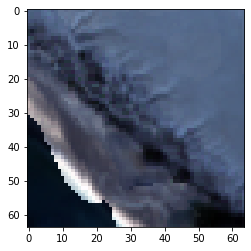

In [5]:
check_data(test_data[2])

Mean: 0.23394149541070625
Max: 0.7347906784904102
Min: -0.4617334009123162
STD: 0.11437879208759619


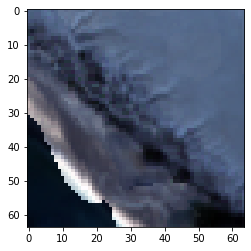

In [6]:
check_data(test_data_unnormalized[2])

## Baseline - utility code

In [7]:
def compute_mse(test_data, forecast_months=7, use_all_years=False):
    """
    Computes mean squared error
    """
    test_set_size = len(test_data)
    progress = progressbar.ProgressBar(test_set_size).start()
    total_mse_per_bands = 0

    for i in range(test_set_size):
        test_inst = test_data[i].numpy()
        
        s = test_inst.shape
        test_inst_by_year = test_inst.reshape(-1, 12, s[1], s[2], s[3])

        # Set y to be latest 7 months
        Y_true = test_inst_by_year[-1][-forecast_months:]
        
        if use_all_years:
            # Set y pred to be average of all past year's 7 months
            Y_pred = test_inst_by_year[:-1].mean(axis=0)[-forecast_months:]
        else:
            # Set y pred to be last year's 7 months
            Y_pred = test_inst_by_year[-2][-forecast_months:]
        
        # Calculate mean squared loss per band
        total_mse_per_bands += ((Y_true - Y_pred)**2).mean(axis=(0,-2,-1))

        progress.update(i+1)
        
    return total_mse_per_bands

In [17]:
def plot_mse_per_bands(mse, bands_to_keep, title="MSE per band"):
    """
    Plots mean squared error per band
    """
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(bands_to_keep, mse)
    ax.set_title(title)

## Baseline - using last years

In [9]:
total_mse_per_bands = compute_mse(test_data)

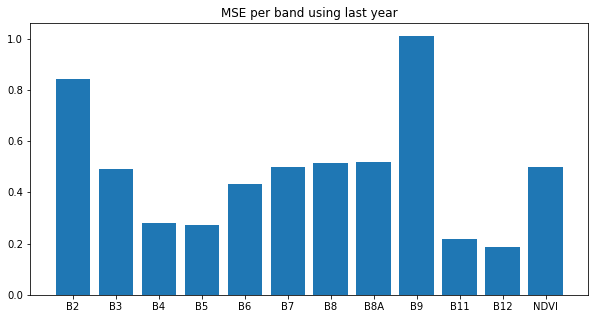

In [18]:
mse = total_mse_per_bands/len(test_data)
plot_mse_per_bands(mse, test_data.bands_to_keep, title="MSE per band using last year");

## Baseline - using last years (unnormalized)

In [10]:
total_mse_per_bands_unnormalized = compute_mse(test_data_unnormalized)

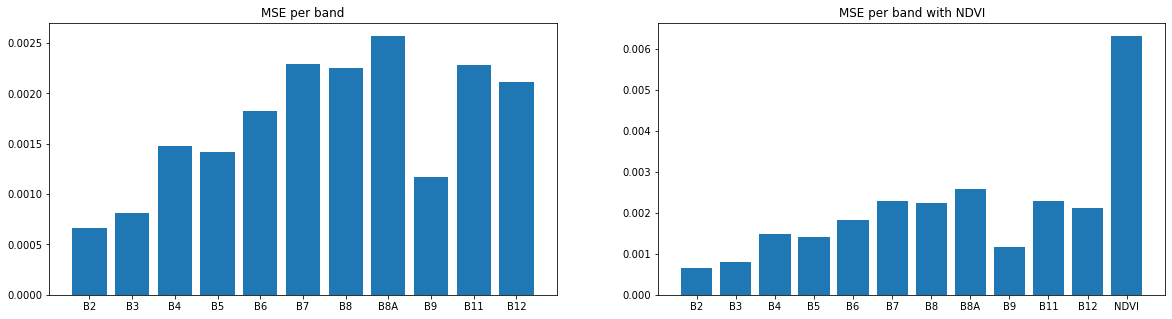

In [11]:
mse_unnormalized = total_mse_per_bands_unnormalized/len(test_data_unnormalized)
plot_mse_per_bands(mse_unnormalized, test_data_unnormalized.bands_to_keep, title="MSE per band using last year (unnormalized)");

## Baseline - using last 4 years average

In [19]:
total_mse_per_bands = compute_mse(test_data, use_all_years=True)

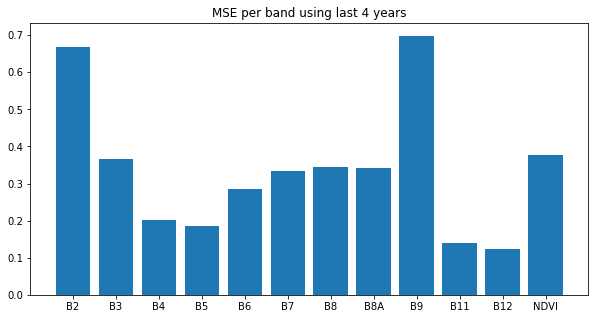

In [20]:
mse = total_mse_per_bands/len(test_data)
plot_mse_per_bands(mse, test_data.bands_to_keep, title="MSE per band using last 4 years");

## Baseline - using last 4 years average (unnormalized)

In [14]:
total_mse_per_bands_unnormalized = compute_mse(test_data_unnormalized, use_all_years=True)

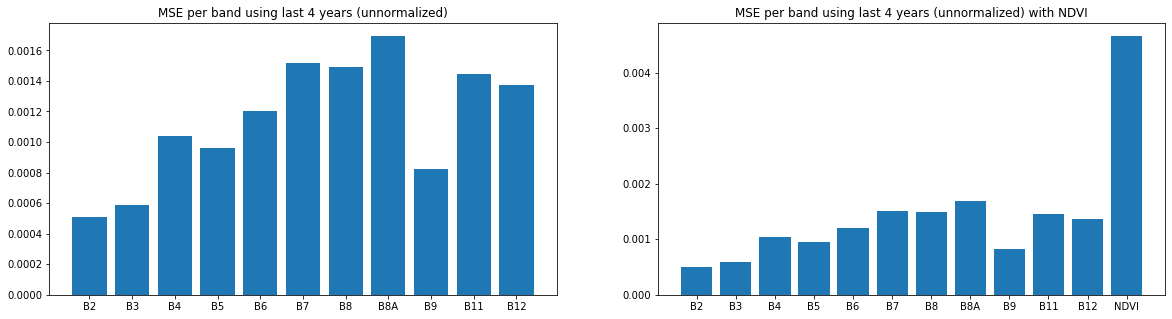

In [17]:
mse_unnormalized = total_mse_per_bands_unnormalized/len(test_data_unnormalized)
plot_mse_per_bands(mse_unnormalized, test_data_unnormalized.bands_to_keep, title="MSE per band using last 4 years (unnormalized)");